# Deep Neural Network

In [4]:
import os
import sys
sys.path.append(os.path.abspath("../../scripts"))
from data_loader import DataLoader
import torch
from torch import optim
import torch.nn as nn
sys.path.append(os.path.abspath("../neural_network"))
from model import NeuralNet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
data_loader = DataLoader()
# Load data
X_train, y_train = data_loader.training_data
X_val, y_val = data_loader.validation_data
X_test, y_test = data_loader.test_data

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


def prepare_data_with_resampling(
    X_train, y_train, X_val, y_val, X_test, y_test, resampling_method=None
):
    
    # Ensure data is converted to NumPy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Apply resampling if a method is specified
    if resampling_method == "random_oversample":
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
    elif resampling_method == "random_undersample":
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    elif resampling_method == "smote":
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    elif resampling_method == "smote_tomek":
        smote_tomek = SMOTETomek(random_state=42)
        X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
    elif resampling_method is not None:
        raise ValueError(f"Unsupported resampling method: {resampling_method}")

    # Convert data to PyTorch tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
        y_train, dtype=torch.long
    )
    X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
        y_val, dtype=torch.long
    )
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(
        y_test, dtype=torch.long
    )

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
# Training function with logging
def train_model(model, train_loader, val_loader, epochs=20):
    history = {'train_loss': [], 'val_loss': [], 'val_metrics': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Evaluate on validation set
        val_loss, val_metrics = evaluate_model(model, val_loader)
        history['val_loss'].append(val_loss)
        history['val_metrics'].append(val_metrics)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Metrics: {val_metrics}")

    return history

In [4]:
# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = (outputs > 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    metrics = {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds),
        "Recall": recall_score(all_labels, all_preds),
        "F1 Score": f1_score(all_labels, all_preds)
    }
    return val_loss / len(loader), metrics

In [5]:
# Specify the resampling method for this run
resampling_method = "smote"  # Options: None, "random_oversample", "random_undersample", "smote", "smote_tomek"

# Prepare DataLoaders with the chosen resampling method
train_loader, val_loader, test_loader = prepare_data_with_resampling(
    X_train, y_train, X_val, y_val, X_test, y_test, resampling_method=resampling_method
)

# Define model, loss, and optimizer
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
input_size = X_train.shape[1]
model = NeuralNet(input_size).to(device)
print(model)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using mps device
NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [6]:
# Train the model
train_progress = train_model(model, train_loader, val_loader, epochs=100)

Epoch 1/100
Train Loss: 0.5184 | Val Loss: 0.5753 | Val Metrics: {'Accuracy': 0.6681352657004831, 'Precision': np.float64(0.30029231995748074), 'Recall': np.float64(0.8312898479646885), 'F1 Score': np.float64(0.44120517993102104)}
Epoch 2/100
Train Loss: 0.5046 | Val Loss: 0.5461 | Val Metrics: {'Accuracy': 0.693256038647343, 'Precision': np.float64(0.31315967851263676), 'Recall': np.float64(0.7930358018636586), 'F1 Score': np.float64(0.44901076015272473)}
Epoch 3/100
Train Loss: 0.4973 | Val Loss: 0.5104 | Val Metrics: {'Accuracy': 0.7208115942028985, 'Precision': np.float64(0.3301295896328294), 'Recall': np.float64(0.7496321726336439), 'F1 Score': np.float64(0.45838956365272154)}
Epoch 4/100
Train Loss: 0.4908 | Val Loss: 0.4725 | Val Metrics: {'Accuracy': 0.7466280193236715, 'Precision': np.float64(0.3517942583732057), 'Recall': np.float64(0.7211868563021089), 'F1 Score': np.float64(0.4729056118347001)}
Epoch 5/100
Train Loss: 0.4845 | Val Loss: 0.4829 | Val Metrics: {'Accuracy': 0.

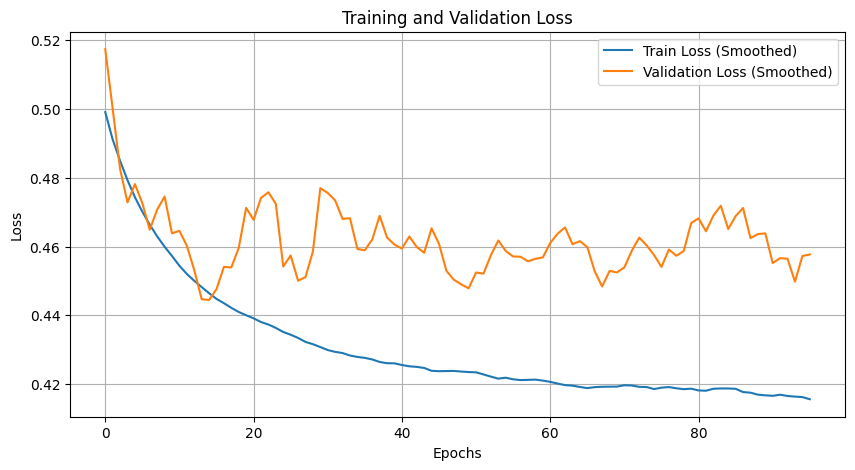

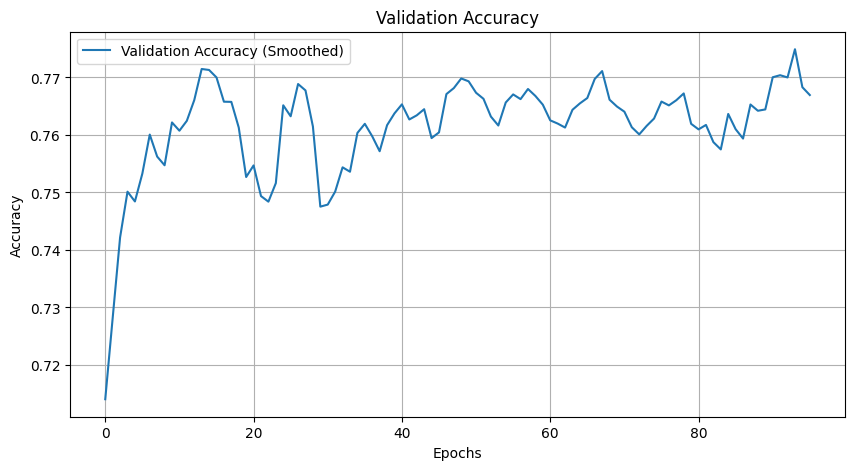

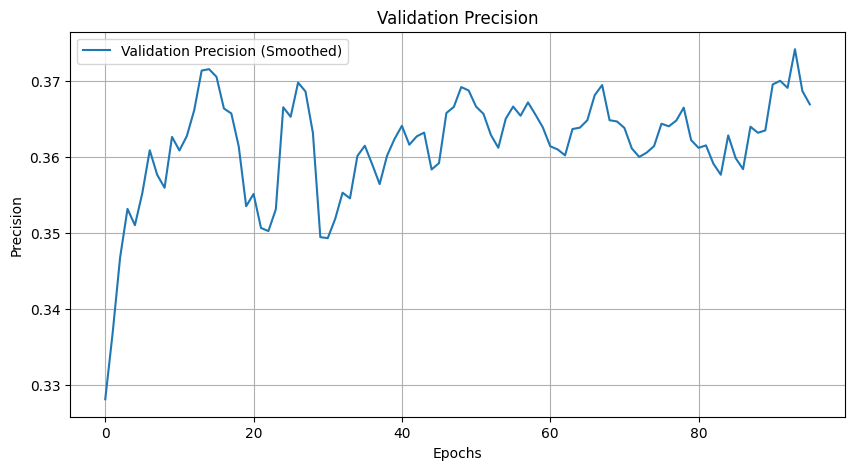

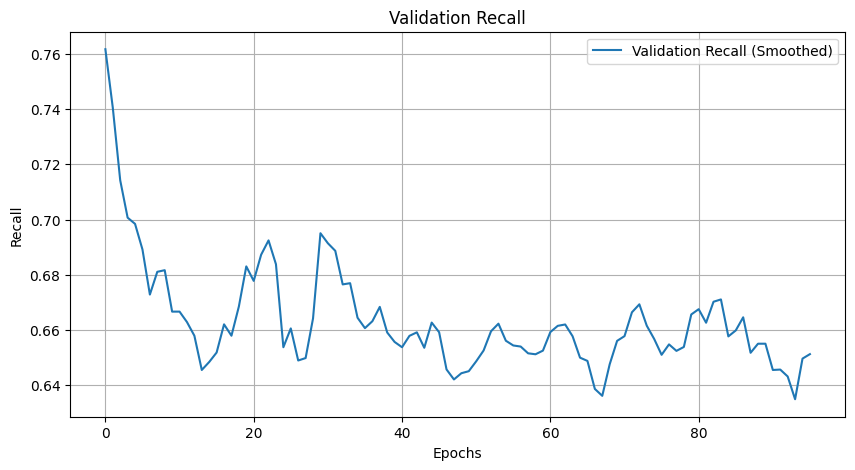

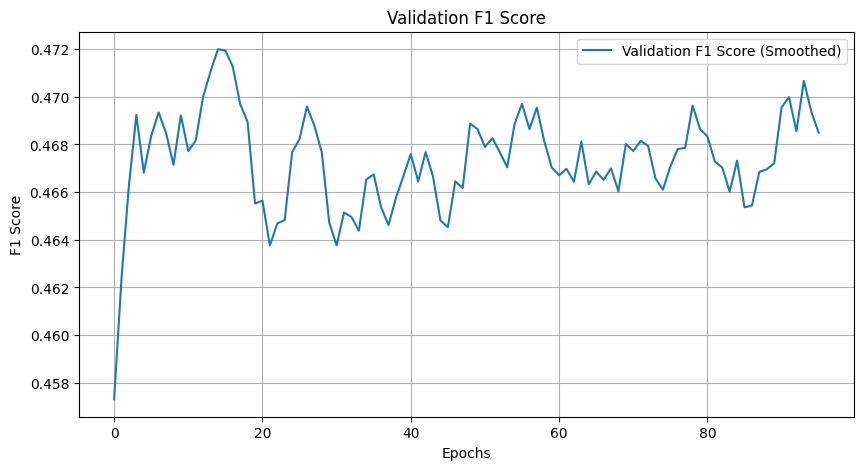

In [13]:
import numpy as np

import matplotlib.pyplot as plt

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_progress(history, window_size=5):
    # Calculate moving averages
    train_loss_smooth = moving_average(history['train_loss'], window_size)
    val_loss_smooth = moving_average(history['val_loss'], window_size)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_smooth, label='Train Loss (Smoothed)')
    plt.plot(val_loss_smooth, label='Validation Loss (Smoothed)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Optionally plot Validation Metrics if available
    if 'val_metrics' in history and history['val_metrics'][0] is not None:
        metrics = history['val_metrics'][0].keys()
        for metric in metrics:
            metric_values = [m[metric] for m in history['val_metrics']]
            metric_smooth = moving_average(metric_values, window_size)
            plt.figure(figsize=(10, 5))
            plt.plot(metric_smooth, label=f'Validation {metric} (Smoothed)')
            plt.title(f'Validation {metric}')
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()
            plt.grid(True)
            plt.show()

# Plot the training progress
plot_training_progress(train_progress)


In [ ]:
# Save the trained model
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f'../../models/neural_net/neural_net_{timestamp}.pkl'

torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../models/neural_net_20241130_195408.pkl


In [ ]:
import torch
from neural_network.model import NeuralNet

# Define the input size (must match the saved model)
input_size = 21  # Number of features

# Instantiate the model and load state dict
model = NeuralNet(input_size)
model_save_path = "../../models/neural_net/neural_net_20241130_195408.pkl"
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set to evaluation mode

# Example usage
X_val_data, _ = data_loader.validation_data
X_val_data = torch.tensor(X_val_data.values, dtype=torch.float32)

with torch.no_grad():
    predictions = (model((X_val_data).squeeze()) > 0.5).long()
    # print("Predictions:", predictions)

/var/folders/mx/80hdp5rj4v550swmwk6ryqmc0000gn/T/ipykernel_95024/194758169.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(y_val, predictions, digits=4, zero_division=0)
print(report)

              precision    recall  f1-score   support

         0.0     0.9199    0.8046    0.8584     21797
         1.0     0.3746    0.6258    0.4687      4078

    accuracy                         0.7764     25875
   macro avg     0.6473    0.7152    0.6635     25875
weighted avg     0.8340    0.7764    0.7970     25875



In [ ]:
import torch
from neural_network.model import NeuralNet

# Define the input size (must match the saved model)
input_size = 21  # Number of features

# Instantiate the model and load state dict
model = NeuralNet(input_size)
model_save_path = "../../models/neural_net/neural_net_20241130_195408.pkl"
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set to evaluation mode

# Example usage
X_test, _ = data_loader.test_data
X_test = torch.tensor(X_test.values, dtype=torch.float32)

with torch.no_grad():
    predictions = (model((X_test).squeeze()) > 0.5).long()
    # print("Predictions:", predictions)


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(y_test, predictions, digits=4, zero_division=0)
print(report)

              precision    recall  f1-score   support

         0.0     0.9191    0.8068    0.8593     42314
         1.0     0.3753    0.6205    0.4677      7915

    accuracy                         0.7775     50229
   macro avg     0.6472    0.7137    0.6635     50229
weighted avg     0.8334    0.7775    0.7976     50229



/var/folders/mx/80hdp5rj4v550swmwk6ryqmc0000gn/T/ipykernel_95024/2994402705.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_